# Generating subglacial topography with Variational Auto Encoder

The keras VAE example at [link](https://keras.io/examples/generative/vae/) is used as a template to create the autoencoder.
To learn about VAEs use this [link](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

Briefly (as per ChatGPT), Variational Autoencoders (VAEs) are like artists who learn to paint pictures. They have a special way of turning a photo into a smaller, simpler code (like a summary of the picture). This code can then be used to recreate the original photo. VAEs add a bit of randomness to their process, making each painting a little different. They learn to make these unique pictures by practicing until they're good at capturing the essence of the photos. So, they're not just copying, but creating new, similar pictures with a touch of creativity. 

Import required libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda, Layer, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, mse
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import periodogram
import gstools as gs
import random

In [2]:
print(tf.__version__)

2.10.1


In [3]:
print(tf.keras.__version__)

2.10.0


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Load the dataset prepared by Andrew which has been scaled and organized into 1564 square sections. The files are currently in [gdrive](https://drive.google.com/file/d/14_BeoL-7z6S1gZy9QzaX8XNQ5VraQ_o9/view?usp=sharing). Github has a 100MB upload limit currently. The link only works with a LDEO google signin. Download this file, unzip and paste the contents in the `data` folder

In [5]:
data = np.load('data/thw_image_stack.npy')

In [6]:
data.shape

(1564, 512, 512, 1)

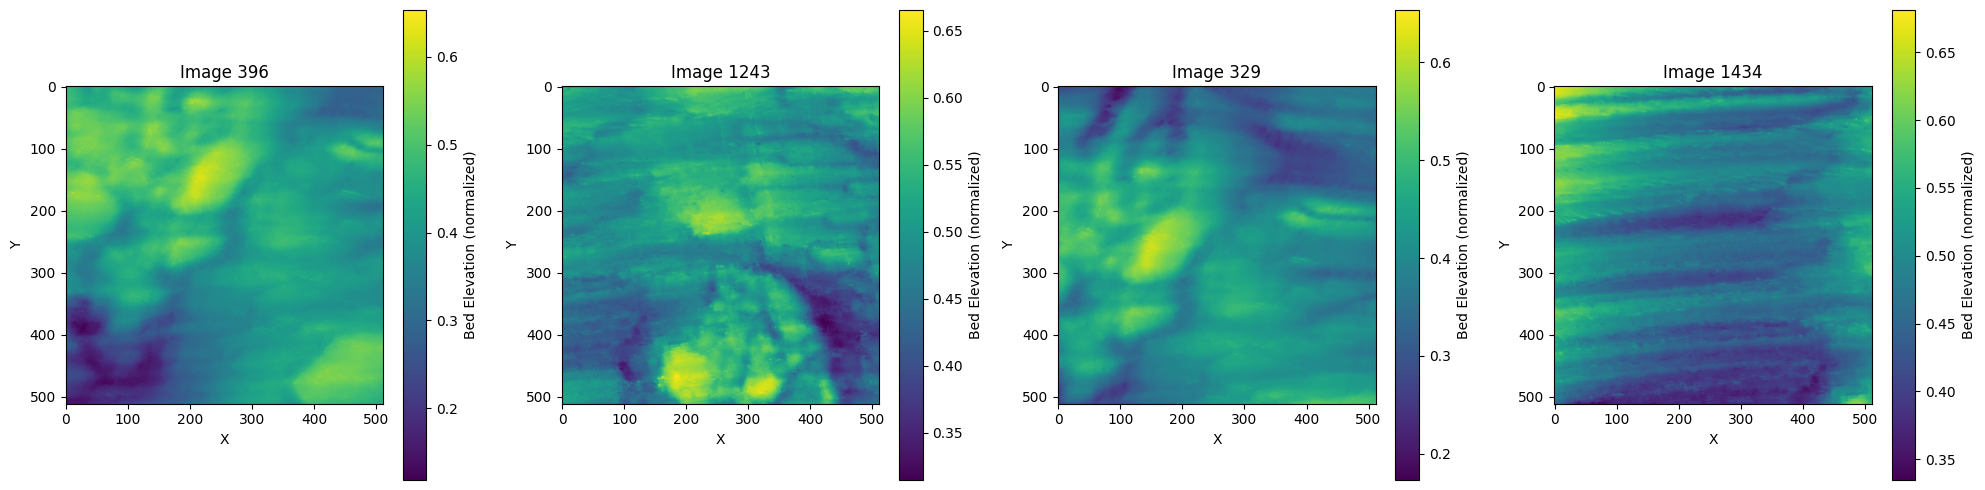

In [7]:
# Select 4 random indices from the dataset
random_indices = np.random.choice(data.shape[0], 4, replace=False)

# Plot the 4 random images
plt.figure(figsize=(20, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 4, i + 1)
    plt.imshow(data[idx].reshape(512, 512), cmap='viridis')
    plt.title(f'Image {idx}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='Bed Elevation (normalized)')
plt.tight_layout()
plt.show()

In [8]:
def compute_variogram_fcn(image, num_samples=50000, num_bins=30):
    """
    Approximate the empirical variogram of an image using sparse sampling.
    
    Parameters:
    - image: 2D numpy array representing the image.
    - num_samples: Number of random pixel pairs to sample.
    - num_bins: Number of bins for distance grouping.
    
    Returns:
    - bin_centers: Centers of the lag bins.
    - gamma: Semi-variance values corresponding to each bin.
    """
    height, width, _ = image.shape

    # Generate random pixel indices for sparse sampling
    y_idx1 = np.random.randint(0, height, size=num_samples)
    x_idx1 = np.random.randint(0, width, size=num_samples)
    y_idx2 = np.random.randint(0, height, size=num_samples)
    x_idx2 = np.random.randint(0, width, size=num_samples)

    # Compute Euclidean distances
    distances = np.sqrt((x_idx1 - x_idx2) ** 2 + (y_idx1 - y_idx2) ** 2)

    # Compute squared differences
    sq_diffs = (image[y_idx1, x_idx1] - image[y_idx2, x_idx2]) ** 2

    # Define bins for distances
    max_dist = np.sqrt(height**2 + width**2) / 3  # Approximate range
    bin_edges = np.linspace(0, max_dist, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Compute semi-variance per bin
    gamma = np.zeros(num_bins)
    for i in range(num_bins):
        mask = (distances >= bin_edges[i]) & (distances < bin_edges[i + 1])
        if np.any(mask):
            gamma[i] = np.mean(sq_diffs[mask]) / 2  # Matheron's estimator

    return bin_centers, gamma


In [9]:
def compute_variogram(image, num_samples=100000, num_bins=30, max_dist=None, random_seed=None):
    """
    Approximate the empirical variogram of an image using sparse sampling.
    
    Parameters:
    - image: 2D numpy array representing the image.
    - num_samples: Number of random pixel pairs to sample (default: 100000).
    - num_bins: Number of bins for distance grouping.
    - max_dist: Maximum distance (lag) to consider; if None, set to half the diagonal.
    - random_seed: Seed for the random number generator (optional).
    
    Returns:
    - bin_centers: Centers of the lag bins.
    - gamma: Semi-variance values corresponding to each bin.
    - counts: Number of pixel pairs contributing to each bin.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    height, width, _ = image.shape

    # Generate random pixel indices for sparse sampling of pairs
    y_idx1 = np.random.randint(0, height, size=num_samples)
    x_idx1 = np.random.randint(0, width, size=num_samples)
    y_idx2 = np.random.randint(0, height, size=num_samples)
    x_idx2 = np.random.randint(0, width, size=num_samples)

    # Compute Euclidean distances between pixel pairs and squared differences
    distances = np.sqrt((x_idx1 - x_idx2) ** 2 + (y_idx1 - y_idx2) ** 2)
    sq_diffs = (image[y_idx1, x_idx1] - image[y_idx2, x_idx2]) ** 2

    # Exclude self-pairs by removing zero distances
    valid = distances > 0
    distances = distances[valid]
    sq_diffs = sq_diffs[valid]

    # Define maximum lag if not provided; default is 1/3 the image diagonal
    if max_dist is None:
        max_dist = np.sqrt(height**2 + width**2) / 3

    # Create bins and assign distances to bins using np.digitize
    bin_edges = np.linspace(0, max_dist, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_inds = np.digitize(distances, bin_edges) - 1  # adjust indices so they start at 0

    # Initialize arrays to hold semi-variance and counts
    gamma = np.zeros(num_bins)
    counts = np.zeros(num_bins, dtype=int)

    # Compute semi-variance in each bin using Matheron's estimator (1/2 * mean squared difference)
    for i in range(num_bins):
        mask = bin_inds == i
        if np.any(mask):
            gamma[i] = np.mean(sq_diffs[mask]) / 2
            counts[i] = np.sum(mask)

    return bin_centers, gamma #, counts


In [127]:
# Number of datasets to compare
n_datasets = 20

# Lists to store variograms for each dataset
all_variograms_gs = []
all_variograms_fcn = []

# Generate n datasets and calculate variograms
for _ in range(n_datasets):
    image = data[np.random.randint(0, data.shape[0])]
    x = range(image.shape[1])
    y = range(image.shape[0])

    # Assuming gs.vario_estimate returns bin_center and gamma
    bin_center_gs, gamma_gs = gs.vario_estimate((x, y), image)
    lag, gamma_example_fcn = compute_variogram(image, num_samples=1000000, num_bins=20)

    all_variograms_gs.append(gamma_gs)
    all_variograms_fcn.append(gamma_example_fcn)
    

# Calculate mean and variance for generated and training data
mean_gs = np.mean(all_variograms_gs, axis=0)
variance_gs = np.var(all_variograms_gs, axis=0)

mean_fcn = np.mean(all_variograms_fcn, axis=0)
variance_fcn = np.var(all_variograms_fcn, axis=0)

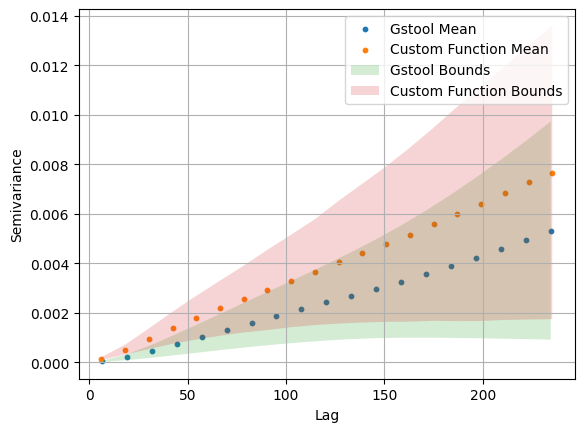

In [128]:
# Plot mean and bounds
plt.scatter(bin_center_gs, mean_gs, label='Gstool Mean', s=10)
plt.scatter(lag, mean_fcn, label='Custom Function Mean', s=10)

plt.fill_between(bin_center_gs, mean_gs - np.sqrt(variance_gs), mean_gs + np.sqrt(variance_gs), alpha=0.2, label='Gstool Bounds')
plt.fill_between(lag, mean_fcn - np.sqrt(variance_fcn), mean_fcn + np.sqrt(variance_fcn), alpha=0.2, label='Custom Function Bounds')

plt.xlabel('Lag')
plt.ylabel('Semivariance')
plt.legend()
plt.grid()
plt.show()

In [9]:
example_image = data[random.randint(0, data.shape[0])]

In [10]:
x = range(example_image.shape[1])
y = range(example_image.shape[0])

# Assuming gs.vario_estimate returns bin_center and gamma
bin_center_example_gs, gamma_example_gs = gs.vario_estimate((x, y), example_image)

In [15]:
lag, gamma_example_fcn = compute_variogram(example_image, num_samples=100000, num_bins=20)

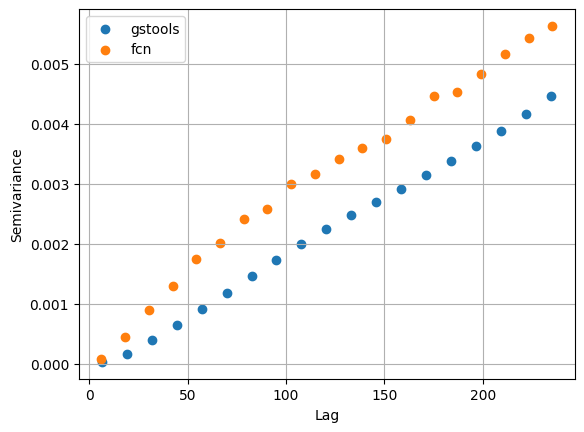

In [16]:
plt.scatter(bin_center_example_gs, gamma_example_gs, label = 'gstools')
plt.scatter(lag, gamma_example_fcn,  label = 'fcn')
plt.xlabel('Lag')
plt.ylabel('Semivariance')
plt.legend()
plt.grid()
plt.show()

# VAE

In [8]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


Encoder of the VAE

In [9]:
latent_dim = 64 # number of latent dimensions, this is a tunable parameter

encoder_inputs = Input(shape=(512, 512, 1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
shape_x = x.shape[1:]
x = Flatten()(x)

x = Dense(latent_dim, activation="relu")(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  18496       ['conv2d[0][0]']                 
                                )                                                           

Decoder of the VAE

In [10]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(shape_x[0] * shape_x[1] * shape_x[2], activation="relu")(latent_inputs)
x = Reshape(shape_x)(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation="linear", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 64)         36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 64)         36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 16, 16, 64)       3692

In [12]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, smoothing_factor=0.99, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        # Loss tracking metrics
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.vario_loss_tracker = tf.keras.metrics.Mean(name="vario_loss")
        self.periodogram_loss_tracker = tf.keras.metrics.Mean(name="periodogram_loss")
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

        # Loss scaling factors (dynamically adjusted)
        self.reconstruction_scale = tf.Variable(1.0, trainable=False, dtype=tf.float32)
        self.kl_scale = tf.Variable(1.0, trainable=False, dtype=tf.float32)
        self.vario_scale = tf.Variable(1.0, trainable=False, dtype=tf.float32)
        self.periodogram_scale = tf.Variable(1.0, trainable=False, dtype=tf.float32)

        # Smoothing factor for scale updates (can be adjusted dynamically)
        self.smoothing_factor = tf.Variable(smoothing_factor, trainable=False, dtype=tf.float32)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.vario_loss_tracker,
            self.periodogram_loss_tracker,
        ]

    @tf.function
    def compute_variogram_tf(self, image, num_samples=100000, num_bins=30, max_dist=None, random_seed=None):
        """
        Computes an approximate empirical variogram for a single image using sparse sampling.

        Args:
            image (tf.Tensor): A tensor of shape (height, width, channels).
            num_samples (int): Number of random pixel pairs to sample.
            num_bins (int): Number of bins to group distances.
            max_dist (float): Maximum lag value to consider. If None, it is set to 1/3 the image diagonal.
            random_seed (int): Seed for the random number generator (optional).

        Returns:
            bin_centers (tf.Tensor): Tensor containing the centers of the lag bins.
            gamma (tf.Tensor): Tensor containing the semi-variance values for each bin.
        """
        # Set the TensorFlow random seed if provided.
        if random_seed is not None:
            tf.random.set_seed(random_seed)

        # Get image dimensions (assumes shape [height, width, channels])
        image_shape = tf.shape(image)
        height = image_shape[0]
        width = image_shape[1]

        # Sample random pixel indices for the first set of pixels.
        y_idx1 = tf.random.uniform((num_samples,), minval=0, maxval=height, dtype=tf.int32, seed=random_seed)
        x_idx1 = tf.random.uniform((num_samples,), minval=0, maxval=width, dtype=tf.int32, seed=random_seed)

        # Use an offset seed for the second set of pixels.
        seed2 = random_seed + 1 if random_seed is not None else None
        y_idx2 = tf.random.uniform((num_samples,), minval=0, maxval=height, dtype=tf.int32, seed=seed2)
        x_idx2 = tf.random.uniform((num_samples,), minval=0, maxval=width, dtype=tf.int32, seed=seed2)

        # Stack indices to form coordinate pairs.
        indices1 = tf.stack([y_idx1, x_idx1], axis=1)
        indices2 = tf.stack([y_idx2, x_idx2], axis=1)

        # Gather pixel values; works for multi-channel images.
        pixel1 = tf.gather_nd(image, indices1)
        pixel2 = tf.gather_nd(image, indices2)

        # Compute squared differences (averaged over channels).
        sq_diffs = tf.reduce_mean(tf.square(tf.cast(pixel1, tf.float32) - tf.cast(pixel2, tf.float32)), axis=-1)

        # Compute Euclidean distances between the pixel coordinates.
        y_idx1_f = tf.cast(y_idx1, tf.float32)
        x_idx1_f = tf.cast(x_idx1, tf.float32)
        y_idx2_f = tf.cast(y_idx2, tf.float32)
        x_idx2_f = tf.cast(x_idx2, tf.float32)
        distances = tf.sqrt(tf.square(x_idx1_f - x_idx2_f) + tf.square(y_idx1_f - y_idx2_f))

        # Remove zero distances (self-pairs).
        valid = distances > 0.0
        distances = tf.boolean_mask(distances, valid)
        sq_diffs = tf.boolean_mask(sq_diffs, valid)

        # Determine max_dist if not provided using 1/3 of the image diagonal.
        if max_dist is None:
            max_dist = tf.sqrt(tf.cast(height, tf.float32) ** 2 + tf.cast(width, tf.float32) ** 2) / 3.0

        # Create bin edges and compute centers.
        bin_edges = tf.linspace(0.0, max_dist, num_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

        # Simulate np.digitize by using tf.searchsorted.
        bin_inds = tf.searchsorted(bin_edges, distances, side='right') - 1

        # Compute semi-variance in each bin using Matheron's estimator.
        def compute_bin(i):
            mask = tf.equal(bin_inds, i)
            sq_diffs_bin = tf.boolean_mask(sq_diffs, mask)
            count = tf.size(sq_diffs_bin)
            semi_variance = tf.cond(
                tf.greater(count, 0),
                lambda: 0.5 * tf.reduce_mean(sq_diffs_bin),
                lambda: tf.constant(0.0, dtype=tf.float32)
            )
            return semi_variance

        gamma = tf.map_fn(compute_bin, tf.range(num_bins), dtype=tf.float32)
        return bin_centers, gamma
    
    @tf.function
    def compute_horizontal_variogram_tf(self, image, num_samples=100000, num_bins=30, max_dist=None, random_seed=None):
        """
        Computes a horizontal (row-wise) empirical variogram for a single image using sparse sampling.

        Args:
            image (tf.Tensor): A tensor of shape (height, width, channels).
            num_samples (int): Number of random pixel pairs to sample.
            num_bins (int): Number of bins to group horizontal distances.
            max_dist (float): Maximum horizontal lag to consider. If None, set to 1/3 image width.
            random_seed (int): Optional seed for reproducibility.

        Returns:
            bin_centers (tf.Tensor): Centers of the horizontal lag bins.
            gamma (tf.Tensor): Semi-variance values for each bin.
        """
        if random_seed is not None:
            tf.random.set_seed(random_seed)

        image_shape = tf.shape(image)
        height = image_shape[0]
        width = image_shape[1]

        # Randomly sample rows and starting columns
        y_idx = tf.random.uniform((num_samples,), minval=0, maxval=height, dtype=tf.int32, seed=random_seed)
        x_idx1 = tf.random.uniform((num_samples,), minval=0, maxval=width, dtype=tf.int32, seed=random_seed)

        # Random horizontal offsets (lag), making sure x2 doesn't go out of bounds
        max_lag = width // 3 if max_dist is None else int(max_dist)
        lag = tf.random.uniform((num_samples,), minval=1, maxval=max_lag, dtype=tf.int32, seed=random_seed)

        x_idx2 = x_idx1 + lag
        valid = x_idx2 < width
        y_idx = tf.boolean_mask(y_idx, valid)
        x_idx1 = tf.boolean_mask(x_idx1, valid)
        x_idx2 = tf.boolean_mask(x_idx2, valid)
        lag = tf.boolean_mask(lag, valid)

        indices1 = tf.stack([y_idx, x_idx1], axis=1)
        indices2 = tf.stack([y_idx, x_idx2], axis=1)

        pixel1 = tf.gather_nd(image, indices1)
        pixel2 = tf.gather_nd(image, indices2)

        sq_diffs = tf.reduce_mean(tf.square(tf.cast(pixel1, tf.float32) - tf.cast(pixel2, tf.float32)), axis=-1)
        distances = tf.cast(lag, tf.float32)

        # Create bins
        max_dist = tf.cast(tf.reduce_max(distances), tf.float32) if max_dist is None else float(max_dist)
        bin_edges = tf.linspace(0.0, max_dist, num_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

        bin_inds = tf.searchsorted(bin_edges, distances, side='right') - 1

        # Semi-variance computation per bin
        def compute_bin(i):
            mask = tf.equal(bin_inds, i)
            sq_diffs_bin = tf.boolean_mask(sq_diffs, mask)
            count = tf.size(sq_diffs_bin)
            semi_variance = tf.cond(
                tf.greater(count, 0),
                lambda: 0.5 * tf.reduce_mean(sq_diffs_bin),
                lambda: tf.constant(0.0, dtype=tf.float32)
            )
            return semi_variance

        gamma = tf.map_fn(compute_bin, tf.range(num_bins), dtype=tf.float32)
        return bin_centers, gamma


    @tf.function
    def compute_variogram_loss(self, original, generated, num_samples=100000, num_bins=30, max_dist=None, random_seed=None):
        """
        Computes a variogram-based loss between original and generated images
        by comparing their empirical variograms computed via sparse sampling.

        Args:
            original (tf.Tensor): Tensor of shape (batch, height, width, channels).
            generated (tf.Tensor): Tensor of shape (batch, height, width, channels).
            num_samples (int): Number of random pixel pairs for variogram computation.
            num_bins (int): Number of bins for grouping distance values.
            max_dist (float): Maximum lag to consider. If None, set to 1/3 the image diagonal.
            random_seed (int): Seed for random sampling (optional).

        Returns:
            tf.Tensor: Scalar loss value computed as the mean squared difference between
                    the variograms of the original and generated images.
        """
        # Compute variogram per image in the batch.
        def compute_loss_per_image(args):
            orig, gen = args
            # Compute variogram for both images.
            #_, gamma_orig = self.compute_variogram_tf(orig, num_samples, num_bins, max_dist, random_seed)
            #_, gamma_gen = self.compute_variogram_tf(gen, num_samples, num_bins, max_dist, random_seed)
            _, gamma_orig = self.compute_horizontal_variogram_tf(orig, num_samples, num_bins, max_dist, random_seed)
            _, gamma_gen = self.compute_horizontal_variogram_tf(gen, num_samples, num_bins, max_dist, random_seed)
            # Loss: squared difference between variogram values.
            return tf.reduce_mean(tf.square(gamma_orig - gamma_gen))

        losses = tf.map_fn(compute_loss_per_image, (original, generated), dtype=tf.float32)
        return tf.reduce_mean(losses)

    def compute_periodogram_loss(self, original, generated, epsilon=1e-8):
        """Computes the difference between periodograms of original and generated images."""
        original = tf.cast(original, tf.complex64)
        generated = tf.cast(generated, tf.complex64)

        fft_original = tf.signal.fft2d(original[..., 0])
        fft_generated = tf.signal.fft2d(generated[..., 0])

        fft_original = tf.signal.fftshift(fft_original, axes=[-2, -1])
        fft_generated = tf.signal.fftshift(fft_generated, axes=[-2, -1])

        power_original = tf.abs(fft_original) ** 2
        power_generated = tf.abs(fft_generated) ** 2

        power_original /= tf.reduce_max(power_original, axis=[1, 2], keepdims=True) + epsilon
        power_generated /= tf.reduce_max(power_generated, axis=[1, 2], keepdims=True) + epsilon

        periodogram_loss = tf.reduce_mean(tf.square(power_original - power_generated))
        return periodogram_loss

    def update_scales(self, reconstruction_loss, kl_loss, vario_loss, periodogram_loss):
        """Dynamically updates the loss scaling factors using exponential smoothing."""
        alpha = self.smoothing_factor  # Dynamic smoothing factor

        self.reconstruction_scale.assign(alpha * self.reconstruction_scale + (1 - alpha) * reconstruction_loss)
        self.kl_scale.assign(alpha * self.kl_scale + (1 - alpha) * kl_loss)
        self.vario_scale.assign(alpha * self.vario_scale + (1 - alpha) * vario_loss)
        self.periodogram_scale.assign(alpha * self.periodogram_scale + (1 - alpha) * periodogram_loss)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Compute raw losses
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            vario_loss = self.compute_variogram_loss(data, reconstruction)
            periodogram_loss = 0 #self.compute_periodogram_loss(data, reconstruction)

            # Update loss scales dynamically
            self.update_scales(reconstruction_loss, kl_loss, vario_loss, periodogram_loss)

            # Compute normalized losses
            normalized_reconstruction_loss = reconstruction_loss / (self.reconstruction_scale + 1e-8)
            normalized_kl_loss = kl_loss / (self.kl_scale + 1e-8)
            normalized_vario_loss = vario_loss / (self.vario_scale + 1e-8)
            normalized_periodogram_loss = periodogram_loss / (self.periodogram_scale + 1e-8)

            # Compute total loss based on normalized values
            # total_loss = (normalized_reconstruction_loss +
            #             normalized_kl_loss +
            #             0.001 * normalized_vario_loss +
            #             0.001 * normalized_periodogram_loss)
            vario_lambda = 1e+7 #1e+7 best value so far, 1e+9 no model convergence, 1e+5 too low
            total_loss = (reconstruction_loss +
                        kl_loss +
                        vario_lambda * vario_loss)
                        #(1e+9) * periodogram_loss)

        # Compute gradients and apply updates
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update loss trackers (store raw losses for early stopping & model checkpoints)
        self.total_loss_tracker.update_state(total_loss)  # Normalized total loss
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)  # Raw loss
        self.kl_loss_tracker.update_state(kl_loss)  # Raw loss
        self.vario_loss_tracker.update_state(vario_lambda * vario_loss)  # Raw loss
        self.periodogram_loss_tracker.update_state(periodogram_loss)  # Raw loss

        return {
            "loss": self.total_loss_tracker.result(),  # Normalized total loss
            "raw_reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "raw_kl_loss": self.kl_loss_tracker.result(),
            "raw_vario_loss": self.vario_loss_tracker.result(),
            # "raw_periodogram_loss": self.periodogram_loss_tracker.result(),
            # "normalized_reconstruction_loss": normalized_reconstruction_loss,
            # "normalized_kl_loss": normalized_kl_loss,
            # "normalized_vario_loss": normalized_vario_loss,
            # "normalized_periodogram_loss": normalized_periodogram_loss,
        }



Create VAE

In [13]:
vae = VAE(encoder, decoder, smoothing_factor=0.90)
vae.compile(optimizer=tf.keras.optimizers.Adam())

Reduce learning rate if a plateau is reached during training

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='raw_reconstruction_loss', factor=0.2,
                              patience=25, min_lr=0.0001)
early_stopping = EarlyStopping(
    monitor="raw_reconstruction_loss",  # Instead of "loss" (which is normalized)
    patience=50,
    restore_best_weights=True
)

Train VAE

In [15]:
epochs = 400
history = vae.fit(data, epochs=epochs, batch_size=8, shuffle=True,  callbacks=[reduce_lr, early_stopping])

Epoch 1/400
Instructions for updating:
Use fn_output_signature instead
196/196 [==============================] - 106s 507ms/step - loss: 22855.7486 - raw_reconstruction_loss: 19231.1380 - raw_kl_loss: 38.8965 - raw_vario_loss: 3585.7111 - lr: 0.0010
Epoch 2/400
196/196 [==============================] - 100s 509ms/step - loss: 2971.7117 - raw_reconstruction_loss: 2832.7582 - raw_kl_loss: 19.7100 - raw_vario_loss: 119.2433 - lr: 0.0010
Epoch 3/400
196/196 [==============================] - 100s 512ms/step - loss: 1147.8768 - raw_reconstruction_loss: 1026.6048 - raw_kl_loss: 77.0912 - raw_vario_loss: 44.1808 - lr: 0.0010
Epoch 4/400
196/196 [==============================] - 101s 513ms/step - loss: 930.4538 - raw_reconstruction_loss: 816.1980 - raw_kl_loss: 82.6537 - raw_vario_loss: 31.6024 - lr: 0.0010
Epoch 5/400
196/196 [==============================] - 102s 520ms/step - loss: 736.9252 - raw_reconstruction_loss: 626.6465 - raw_kl_loss: 85.7494 - raw_vario_loss: 24.5292 - lr: 0.0010


Save VAE (This hasn't been tested)

In [16]:
vae.get_layer('encoder').save_weights('encoder_weights.h5')
vae.get_layer('decoder').save_weights('decoder_weights.h5')


#Since both encoder and decoder are treated as models, you also need to save their architecture defined via instantiated VAE model
vae.get_layer('encoder').save('encoder_arch')
vae.get_layer('decoder').save('decoder_arch')

INFO:tensorflow:Assets written to: encoder_arch\assets


INFO:tensorflow:Assets written to: encoder_arch\assets


INFO:tensorflow:Assets written to: decoder_arch\assets


INFO:tensorflow:Assets written to: decoder_arch\assets


Plot loss to check for convergence

In [17]:
total_loss = history.history['loss']
reconstruction_loss = history.history['raw_reconstruction_loss']
kl_loss = history.history["raw_kl_loss"]
vario_loss = history.history["raw_vario_loss"]
#periodogram_loss = history.history["raw_periodogram_loss"]
#total_loss = reconstruction_loss + kl_loss + vario_loss #+ periodogram_loss

Text(0, 0.5, 'loss')

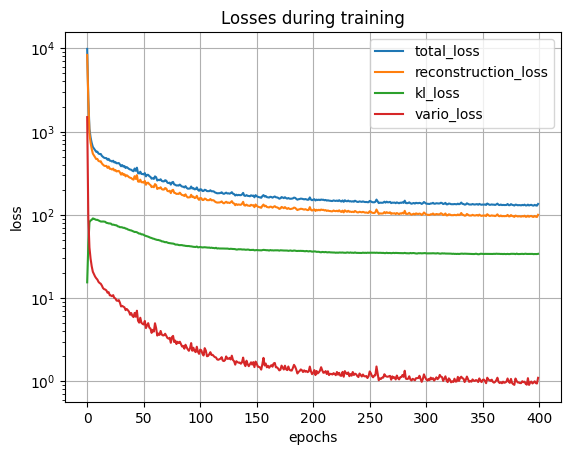

In [18]:
plt.semilogy(total_loss, label = 'total_loss')
plt.semilogy(reconstruction_loss, label = 'reconstruction_loss')
plt.semilogy(kl_loss, label = 'kl_loss')
plt.semilogy(vario_loss, label = 'vario_loss')
#plt.semilogy(periodogram_loss, label = 'periodogram_loss')
plt.title('Losses during training')
plt.grid()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

Generate random beds by sampling the latent space

1/1 [==============================] - 1s 1s/step


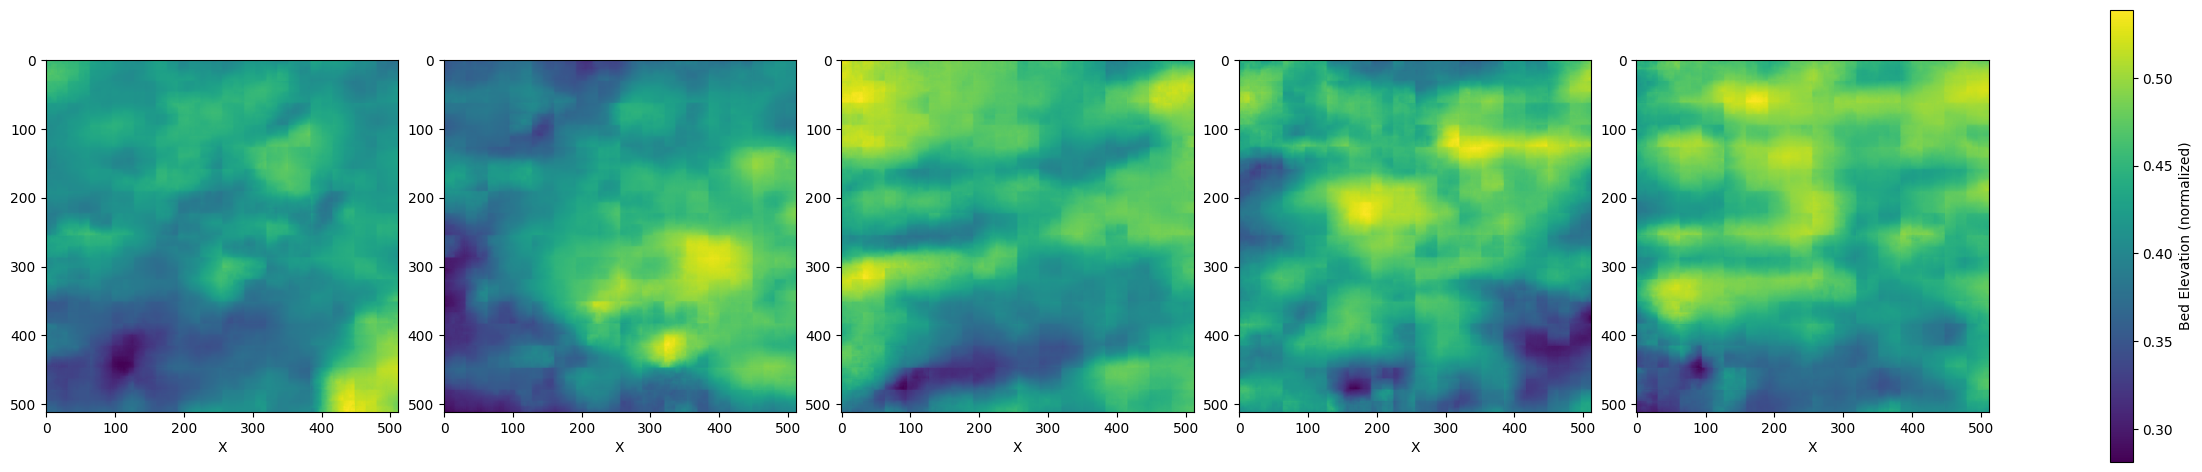

In [19]:
def generate_images(decoder, n=5):
    # Sample from the latent space
    #latent_dim = 128  # This is the latent_dim defined in the VAE model
    random_latent_vectors = np.random.normal(size=(n, latent_dim))

    # Decode to generate images
    generated_images = decoder.predict(random_latent_vectors)

    return generated_images

# Generate new images
new_images = generate_images(decoder, n=5)

# Plot the generated images
plt.figure(figsize=(25, 5))

for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    img = plt.imshow(new_images[i].reshape(512, 512))
    plt.xlabel('X')

# Add a single color bar for all subplots
plt.tight_layout()
cbar = plt.colorbar(img, ax=[ax for ax in plt.gcf().axes], label='Bed Elevation (normalized)')

plt.show()



Generate multiple samples and plot variograms to compute mean and variance of the topographs produced by the vae. Compare them against the training data

In [20]:
def generate_data(data):
    # Replace this with your data generation logic
    #image_number = np.random.randint(0, new_images.shape[0] - 1)
    training_number = np.random.randint(0, data.shape[0] - 1)
    generated_image = generate_images(decoder, 1).reshape(512,512,1)
    training_image = data[training_number]
    return generated_image, training_image

# Number of datasets to generate
n_datasets = 500

# Lists to store variograms for each dataset
all_variograms_generated = []
all_variograms_training = []

# Generate n datasets and calculate variograms
for _ in range(n_datasets):
    generated_image, training_image = generate_data(data)
    x = range(generated_image.shape[1])
    y = range(generated_image.shape[0])

    # Assuming gs.vario_estimate returns bin_center and gamma
    bin_center_generated, gamma_generated = gs.vario_estimate((x, y), generated_image)
    bin_center_training, gamma_training = gs.vario_estimate((x, y), training_image)

    all_variograms_generated.append(gamma_generated)
    all_variograms_training.append(gamma_training)

# Calculate mean and variance for generated and training data
mean_generated = np.mean(all_variograms_generated, axis=0)
variance_generated = np.var(all_variograms_generated, axis=0)

mean_training = np.mean(all_variograms_training, axis=0)
variance_training = np.var(all_variograms_training, axis=0)

1/1 [==============================] - 0s 16ms/step


Plot variogram mean and variance for VAE generated topographs and training data

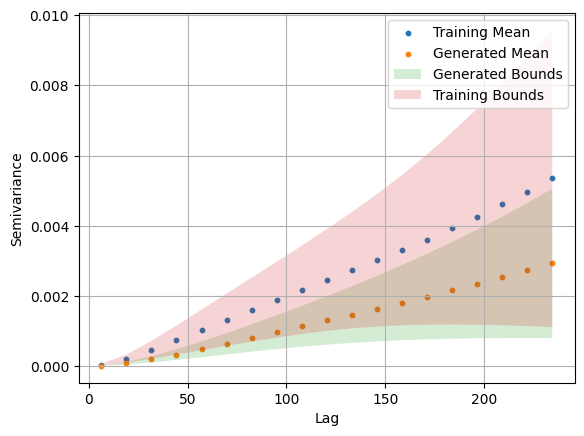

In [21]:
# Plot mean and bounds
plt.scatter(bin_center_training, mean_training, label='Training Mean', s=10)
plt.scatter(bin_center_generated, mean_generated, label='Generated Mean', s=10)

plt.fill_between(bin_center_generated, mean_generated - np.sqrt(variance_generated), mean_generated + np.sqrt(variance_generated), alpha=0.2, label='Generated Bounds')
plt.fill_between(bin_center_training, mean_training - np.sqrt(variance_training), mean_training + np.sqrt(variance_training), alpha=0.2, label='Training Bounds')

plt.xlabel('Lag')
plt.ylabel('Semivariance')
plt.legend()
plt.grid()
plt.show()

Plot periodogram mean and variance for VAE generated topographs and training data

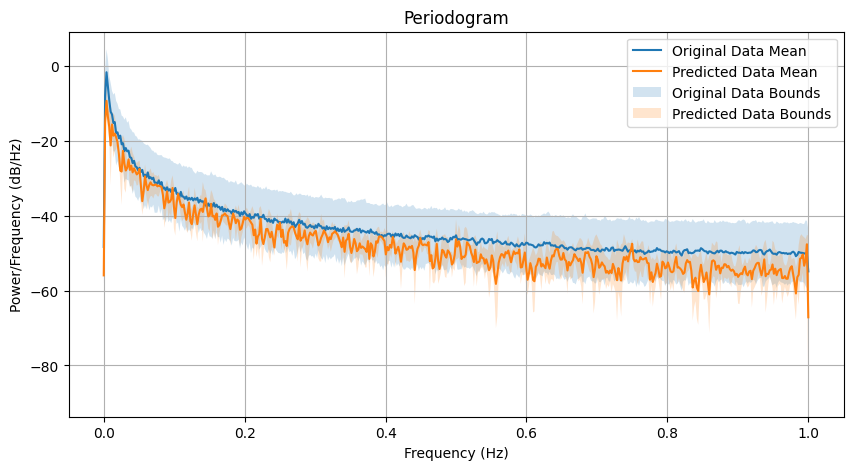

In [22]:
def generate_data(data):
    training_number = np.random.randint(0, data.shape[0] - 1)
    image_number = np.random.randint(0, new_images.shape[0] - 1)
    array1 = data[training_number].reshape(-1)
    array2 = new_images[image_number].reshape(-1)
    return array1, array2

# Number of datasets to generate
n_datasets = 100

# Lists to store periodograms for each dataset
all_periodograms_original = []
all_periodograms_predicted = []

# Generate n datasets and calculate periodograms
for _ in range(n_datasets):
    array1, array2 = generate_data(data)
    
    # Calculate periodogram using scipy.signal.periodogram
    freqs1, psd1 = periodogram(array1, fs=2, nfft=1024, window='hann')
    freqs2, psd2 = periodogram(array2, fs=2, nfft=1024, window='hann')
    
    all_periodograms_original.append(10 * np.log10(psd1))  # Convert to dB for better visualization
    all_periodograms_predicted.append(10 * np.log10(psd2))  # Convert to dB for better visualization

# Calculate mean and variance for original and predicted data
mean_original = np.mean(all_periodograms_original, axis=0)
variance_original = np.var(all_periodograms_original, axis=0)

mean_predicted = np.mean(all_periodograms_predicted, axis=0)
variance_predicted = np.var(all_periodograms_predicted, axis=0)

# Plot mean and bounds for periodogram
plt.figure(figsize=(10, 5))
plt.plot(freqs1, mean_original, label='Original Data Mean')
plt.plot(freqs2, mean_predicted, label='Predicted Data Mean')

plt.fill_between(freqs1, mean_original - np.sqrt(variance_original), mean_original + np.sqrt(variance_original), alpha=0.2, label='Original Data Bounds')
plt.fill_between(freqs2, mean_predicted - np.sqrt(variance_predicted), mean_predicted + np.sqrt(variance_predicted), alpha=0.2, label='Predicted Data Bounds')

plt.title('Periodogram')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid(True)
plt.show()

The variogram suggests that most of the topographs generated by the VAE lie within the bounds of the training dataset. Although there does seem to be a bias. The periodogram is also similar to the training data but with a some noise addded at all frequencies. 

In [31]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, smoothing_factor=0.99, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        # Loss tracking metrics
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.vario_loss_tracker = tf.keras.metrics.Mean(name="vario_loss")
        self.periodogram_loss_tracker = tf.keras.metrics.Mean(name="periodogram_loss")
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

        # Loss scaling factors (dynamically adjusted)
        self.reconstruction_scale = tf.Variable(1.0, trainable=False, dtype=tf.float32)
        self.kl_scale = tf.Variable(1.0, trainable=False, dtype=tf.float32)
        self.vario_scale = tf.Variable(1.0, trainable=False, dtype=tf.float32)
        self.periodogram_scale = tf.Variable(1.0, trainable=False, dtype=tf.float32)

        # Smoothing factor for scale updates (can be adjusted dynamically)
        self.smoothing_factor = tf.Variable(smoothing_factor, trainable=False, dtype=tf.float32)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.vario_loss_tracker,
            self.periodogram_loss_tracker,
        ]

    @tf.function
    def compute_variogram_tf(self, image, num_samples=100000, num_bins=30, max_dist=None, random_seed=None):
        """
        Computes an approximate empirical variogram for a single image using sparse sampling.

        Args:
            image (tf.Tensor): A tensor of shape (height, width, channels).
            num_samples (int): Number of random pixel pairs to sample.
            num_bins (int): Number of bins to group distances.
            max_dist (float): Maximum lag value to consider. If None, it is set to 1/3 the image diagonal.
            random_seed (int): Seed for the random number generator (optional).

        Returns:
            bin_centers (tf.Tensor): Tensor containing the centers of the lag bins.
            gamma (tf.Tensor): Tensor containing the semi-variance values for each bin.
        """
        # Set the TensorFlow random seed if provided.
        if random_seed is not None:
            tf.random.set_seed(random_seed)

        # Get image dimensions (assumes shape [height, width, channels])
        image_shape = tf.shape(image)
        height = image_shape[0]
        width = image_shape[1]

        # Sample random pixel indices for the first set of pixels.
        y_idx1 = tf.random.uniform((num_samples,), minval=0, maxval=height, dtype=tf.int32, seed=random_seed)
        x_idx1 = tf.random.uniform((num_samples,), minval=0, maxval=width, dtype=tf.int32, seed=random_seed)

        # Use an offset seed for the second set of pixels.
        seed2 = random_seed + 1 if random_seed is not None else None
        y_idx2 = tf.random.uniform((num_samples,), minval=0, maxval=height, dtype=tf.int32, seed=seed2)
        x_idx2 = tf.random.uniform((num_samples,), minval=0, maxval=width, dtype=tf.int32, seed=seed2)

        # Stack indices to form coordinate pairs.
        indices1 = tf.stack([y_idx1, x_idx1], axis=1)
        indices2 = tf.stack([y_idx2, x_idx2], axis=1)

        # Gather pixel values; works for multi-channel images.
        pixel1 = tf.gather_nd(image, indices1)
        pixel2 = tf.gather_nd(image, indices2)

        # Compute squared differences (averaged over channels).
        sq_diffs = tf.reduce_mean(tf.square(tf.cast(pixel1, tf.float32) - tf.cast(pixel2, tf.float32)), axis=-1)

        # Compute Euclidean distances between the pixel coordinates.
        y_idx1_f = tf.cast(y_idx1, tf.float32)
        x_idx1_f = tf.cast(x_idx1, tf.float32)
        y_idx2_f = tf.cast(y_idx2, tf.float32)
        x_idx2_f = tf.cast(x_idx2, tf.float32)
        distances = tf.sqrt(tf.square(x_idx1_f - x_idx2_f) + tf.square(y_idx1_f - y_idx2_f))

        # Remove zero distances (self-pairs).
        valid = distances > 0.0
        distances = tf.boolean_mask(distances, valid)
        sq_diffs = tf.boolean_mask(sq_diffs, valid)

        # Determine max_dist if not provided using 1/3 of the image diagonal.
        if max_dist is None:
            max_dist = tf.sqrt(tf.cast(height, tf.float32) ** 2 + tf.cast(width, tf.float32) ** 2) / 3.0

        # Create bin edges and compute centers.
        bin_edges = tf.linspace(0.0, max_dist, num_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

        # Simulate np.digitize by using tf.searchsorted.
        bin_inds = tf.searchsorted(bin_edges, distances, side='right') - 1

        # Compute semi-variance in each bin using Matheron's estimator.
        def compute_bin(i):
            mask = tf.equal(bin_inds, i)
            sq_diffs_bin = tf.boolean_mask(sq_diffs, mask)
            count = tf.size(sq_diffs_bin)
            semi_variance = tf.cond(
                tf.greater(count, 0),
                lambda: 0.5 * tf.reduce_mean(sq_diffs_bin),
                lambda: tf.constant(0.0, dtype=tf.float32)
            )
            return semi_variance

        gamma = tf.map_fn(compute_bin, tf.range(num_bins), dtype=tf.float32)
        return bin_centers, gamma
    
    @tf.function
    def compute_horizontal_variogram_tf(self, image, num_samples=100000, num_bins=30, max_dist=None, random_seed=None):
        """
        Computes a horizontal (row-wise) empirical variogram for a single image using sparse sampling.

        Args:
            image (tf.Tensor): A tensor of shape (height, width, channels).
            num_samples (int): Number of random pixel pairs to sample.
            num_bins (int): Number of bins to group horizontal distances.
            max_dist (float): Maximum horizontal lag to consider. If None, set to 1/3 image width.
            random_seed (int): Optional seed for reproducibility.

        Returns:
            bin_centers (tf.Tensor): Centers of the horizontal lag bins.
            gamma (tf.Tensor): Semi-variance values for each bin.
        """
        if random_seed is not None:
            tf.random.set_seed(random_seed)

        image_shape = tf.shape(image)
        height = image_shape[0]
        width = image_shape[1]

        # Randomly sample rows and starting columns
        y_idx = tf.random.uniform((num_samples,), minval=0, maxval=height, dtype=tf.int32, seed=random_seed)
        x_idx1 = tf.random.uniform((num_samples,), minval=0, maxval=width, dtype=tf.int32, seed=random_seed)

        # Random horizontal offsets (lag), making sure x2 doesn't go out of bounds
        max_lag = width // 3 if max_dist is None else int(max_dist)
        lag = tf.random.uniform((num_samples,), minval=1, maxval=max_lag, dtype=tf.int32, seed=random_seed)

        x_idx2 = x_idx1 + lag
        valid = x_idx2 < width
        y_idx = tf.boolean_mask(y_idx, valid)
        x_idx1 = tf.boolean_mask(x_idx1, valid)
        x_idx2 = tf.boolean_mask(x_idx2, valid)
        lag = tf.boolean_mask(lag, valid)

        indices1 = tf.stack([y_idx, x_idx1], axis=1)
        indices2 = tf.stack([y_idx, x_idx2], axis=1)

        pixel1 = tf.gather_nd(image, indices1)
        pixel2 = tf.gather_nd(image, indices2)

        sq_diffs = tf.reduce_mean(tf.square(tf.cast(pixel1, tf.float32) - tf.cast(pixel2, tf.float32)), axis=-1)
        distances = tf.cast(lag, tf.float32)

        # Create bins
        max_dist = tf.cast(tf.reduce_max(distances), tf.float32) if max_dist is None else float(max_dist)
        bin_edges = tf.linspace(0.0, max_dist, num_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

        bin_inds = tf.searchsorted(bin_edges, distances, side='right') - 1

        # Semi-variance computation per bin
        def compute_bin(i):
            mask = tf.equal(bin_inds, i)
            sq_diffs_bin = tf.boolean_mask(sq_diffs, mask)
            count = tf.size(sq_diffs_bin)
            semi_variance = tf.cond(
                tf.greater(count, 0),
                lambda: 0.5 * tf.reduce_mean(sq_diffs_bin),
                lambda: tf.constant(0.0, dtype=tf.float32)
            )
            return semi_variance

        gamma = tf.map_fn(compute_bin, tf.range(num_bins), dtype=tf.float32)
        return bin_centers, gamma


    @tf.function
    def compute_variogram_loss(self, original, generated, num_samples=100000, num_bins=30, max_dist=None, random_seed=None):
        """
        Computes a variogram-based loss between original and generated images
        by comparing their empirical variograms computed via sparse sampling.

        Args:
            original (tf.Tensor): Tensor of shape (batch, height, width, channels).
            generated (tf.Tensor): Tensor of shape (batch, height, width, channels).
            num_samples (int): Number of random pixel pairs for variogram computation.
            num_bins (int): Number of bins for grouping distance values.
            max_dist (float): Maximum lag to consider. If None, set to 1/3 the image diagonal.
            random_seed (int): Seed for random sampling (optional).

        Returns:
            tf.Tensor: Scalar loss value computed as the mean squared difference between
                    the variograms of the original and generated images.
        """
        # Compute variogram per image in the batch.
        def compute_loss_per_image(args):
            orig, gen = args
            # Compute variogram for both images.
            #_, gamma_orig = self.compute_variogram_tf(orig, num_samples, num_bins, max_dist, random_seed)
            #_, gamma_gen = self.compute_variogram_tf(gen, num_samples, num_bins, max_dist, random_seed)
            _, gamma_orig = self.compute_horizontal_variogram_tf(orig, num_samples, num_bins, max_dist, random_seed)
            _, gamma_gen = self.compute_horizontal_variogram_tf(gen, num_samples, num_bins, max_dist, random_seed)
            # Loss: squared difference between variogram values.
            return tf.reduce_mean(tf.square(gamma_orig - gamma_gen))

        losses = tf.map_fn(compute_loss_per_image, (original, generated), dtype=tf.float32)
        return tf.reduce_mean(losses)

    def compute_periodogram_loss(self, original, generated, epsilon=1e-8):
        """Computes the difference between periodograms of original and generated images."""
        original = tf.cast(original, tf.complex64)
        generated = tf.cast(generated, tf.complex64)

        fft_original = tf.signal.fft2d(original[..., 0])
        fft_generated = tf.signal.fft2d(generated[..., 0])

        fft_original = tf.signal.fftshift(fft_original, axes=[-2, -1])
        fft_generated = tf.signal.fftshift(fft_generated, axes=[-2, -1])

        power_original = tf.abs(fft_original) ** 2
        power_generated = tf.abs(fft_generated) ** 2

        power_original /= tf.reduce_max(power_original, axis=[1, 2], keepdims=True) + epsilon
        power_generated /= tf.reduce_max(power_generated, axis=[1, 2], keepdims=True) + epsilon

        periodogram_loss = tf.reduce_mean(tf.square(power_original - power_generated))
        return periodogram_loss

    def update_scales(self, reconstruction_loss, kl_loss, vario_loss, periodogram_loss):
        """Dynamically updates the loss scaling factors using exponential smoothing."""
        alpha = self.smoothing_factor  # Dynamic smoothing factor

        self.reconstruction_scale.assign(alpha * self.reconstruction_scale + (1 - alpha) * reconstruction_loss)
        self.kl_scale.assign(alpha * self.kl_scale + (1 - alpha) * kl_loss)
        self.vario_scale.assign(alpha * self.vario_scale + (1 - alpha) * vario_loss)
        self.periodogram_scale.assign(alpha * self.periodogram_scale + (1 - alpha) * periodogram_loss)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Compute raw losses
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            vario_loss = self.compute_variogram_loss(data, reconstruction)
            periodogram_loss = 0 #self.compute_periodogram_loss(data, reconstruction)

            # Update loss scales dynamically
            self.update_scales(reconstruction_loss, kl_loss, vario_loss, periodogram_loss)

            # Compute normalized losses
            normalized_reconstruction_loss = reconstruction_loss / (self.reconstruction_scale + 1e-8)
            normalized_kl_loss = kl_loss / (self.kl_scale + 1e-8)
            normalized_vario_loss = vario_loss / (self.vario_scale + 1e-8)
            normalized_periodogram_loss = periodogram_loss / (self.periodogram_scale + 1e-8)

            # Compute total loss based on normalized values
            # total_loss = (normalized_reconstruction_loss +
            #             normalized_kl_loss +
            #             0.001 * normalized_vario_loss +
            #             0.001 * normalized_periodogram_loss)
            vario_lambda = 1e+7 #1e+7 best value so far, 1e+9 no model convergence, 1e+5 too low
            kl_lambda = 10
            total_loss = (reconstruction_loss +
                        kl_lambda * kl_loss +
                        vario_lambda * vario_loss)
                        #(1e+9) * periodogram_loss)

        # Compute gradients and apply updates
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update loss trackers (store raw losses for early stopping & model checkpoints)
        self.total_loss_tracker.update_state(total_loss)  # Normalized total loss
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)  # Raw loss
        self.kl_loss_tracker.update_state(kl_loss)  # Raw loss
        self.vario_loss_tracker.update_state(vario_lambda * vario_loss)  # Raw loss
        self.periodogram_loss_tracker.update_state(periodogram_loss)  # Raw loss

        return {
            "loss": self.total_loss_tracker.result(),  # Normalized total loss
            "raw_reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "raw_kl_loss": self.kl_loss_tracker.result(),
            "raw_vario_loss": self.vario_loss_tracker.result(),
            # "raw_periodogram_loss": self.periodogram_loss_tracker.result(),
            # "normalized_reconstruction_loss": normalized_reconstruction_loss,
            # "normalized_kl_loss": normalized_kl_loss,
            # "normalized_vario_loss": normalized_vario_loss,
            # "normalized_periodogram_loss": normalized_periodogram_loss,
        }



In [32]:
vae = VAE(encoder, decoder, smoothing_factor=0.90)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [ ]:
epochs = 400
history = vae.fit(data, epochs=epochs, batch_size=8, shuffle=True,  callbacks=[reduce_lr, early_stopping])

In [ ]:
total_loss = history.history['loss']
reconstruction_loss = history.history['raw_reconstruction_loss']
kl_loss = history.history["raw_kl_loss"]
vario_loss = history.history["raw_vario_loss"]
#periodogram_loss = history.history["raw_periodogram_loss"]
#total_loss = reconstruction_loss + kl_loss + vario_loss #+ periodogram_loss

Text(0, 0.5, 'loss')

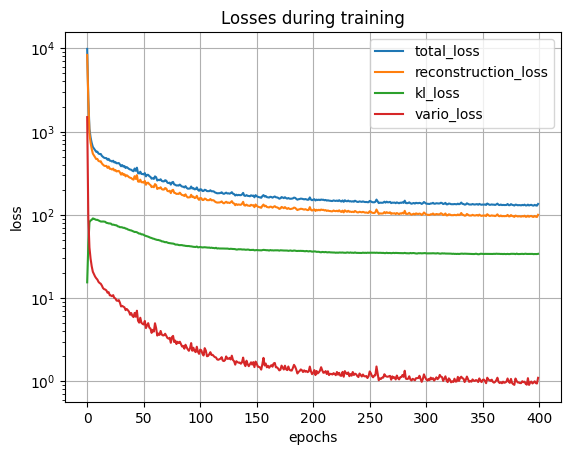

In [28]:
plt.semilogy(total_loss, label = 'total_loss')
plt.semilogy(reconstruction_loss, label = 'reconstruction_loss')
plt.semilogy(kl_loss, label = 'kl_loss')
plt.semilogy(vario_loss, label = 'vario_loss')
#plt.semilogy(periodogram_loss, label = 'periodogram_loss')
plt.title('Losses during training')
plt.grid()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

1/1 [==============================] - 0s 22ms/step


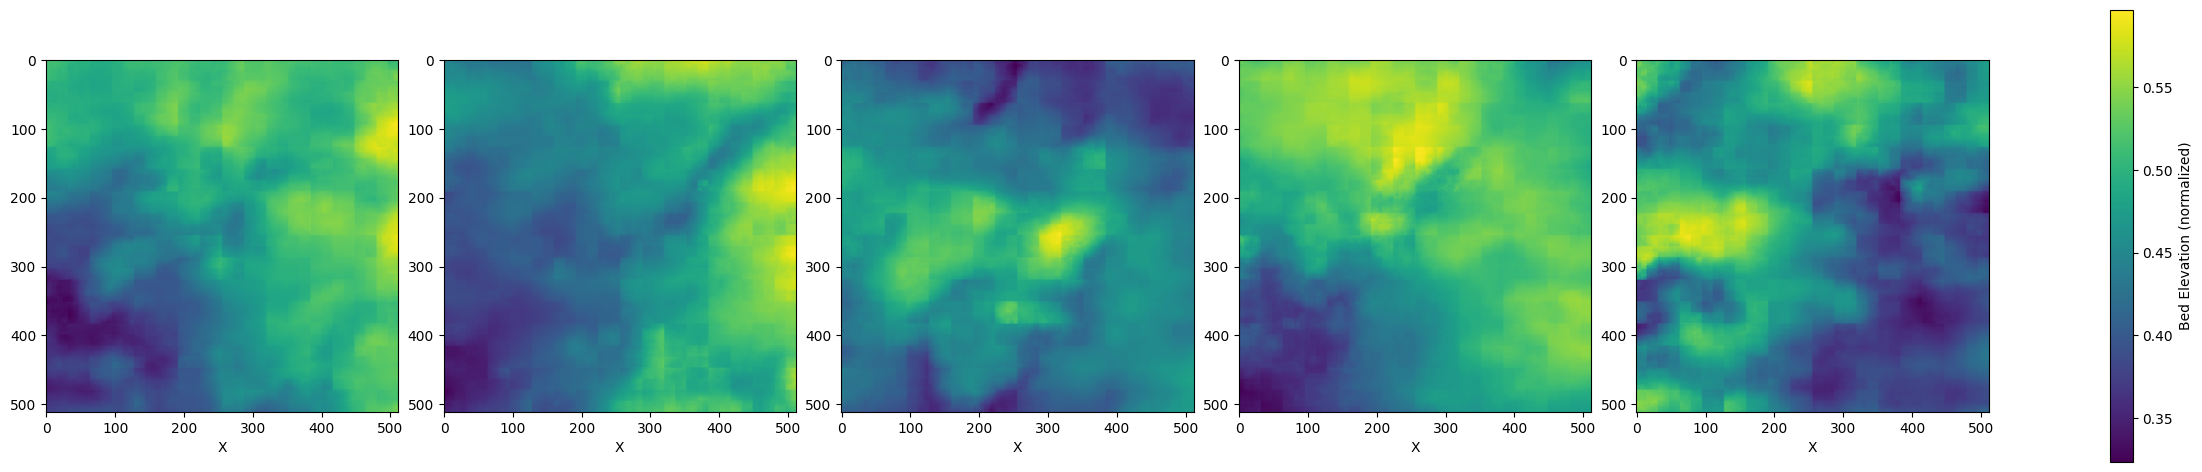

In [30]:
def generate_images(decoder, n=5):
    # Sample from the latent space
    #latent_dim = 128  # This is the latent_dim defined in the VAE model
    random_latent_vectors = np.random.normal(size=(n, latent_dim))

    # Decode to generate images
    generated_images = decoder.predict(random_latent_vectors)

    return generated_images

# Generate new images
new_images = generate_images(decoder, n=5)

# Plot the generated images
plt.figure(figsize=(25, 5))

for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    img = plt.imshow(new_images[i].reshape(512, 512))
    plt.xlabel('X')

# Add a single color bar for all subplots
plt.tight_layout()
cbar = plt.colorbar(img, ax=[ax for ax in plt.gcf().axes], label='Bed Elevation (normalized)')

plt.show()



In [26]:
def generate_data(data):
    # Replace this with your data generation logic
    #image_number = np.random.randint(0, new_images.shape[0] - 1)
    training_number = np.random.randint(0, data.shape[0] - 1)
    generated_image = generate_images(decoder, 1).reshape(512,512,1)
    training_image = data[training_number]
    return generated_image, training_image

# Number of datasets to generate
n_datasets = 500

# Lists to store variograms for each dataset
all_variograms_generated = []
all_variograms_training = []

# Generate n datasets and calculate variograms
for _ in range(n_datasets):
    generated_image, training_image = generate_data(data)
    x = range(generated_image.shape[1])
    y = range(generated_image.shape[0])

    # Assuming gs.vario_estimate returns bin_center and gamma
    bin_center_generated, gamma_generated = gs.vario_estimate((x, y), generated_image)
    bin_center_training, gamma_training = gs.vario_estimate((x, y), training_image)

    all_variograms_generated.append(gamma_generated)
    all_variograms_training.append(gamma_training)

# Calculate mean and variance for generated and training data
mean_generated = np.mean(all_variograms_generated, axis=0)
variance_generated = np.var(all_variograms_generated, axis=0)

mean_training = np.mean(all_variograms_training, axis=0)
variance_training = np.var(all_variograms_training, axis=0)

1/1 [==============================] - 0s 15ms/step


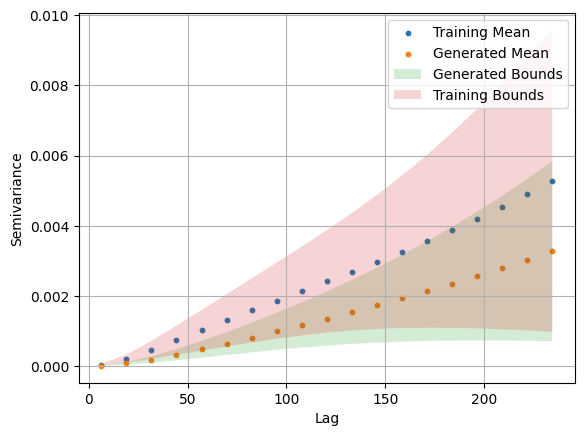

In [27]:
# Plot mean and bounds
plt.scatter(bin_center_training, mean_training, label='Training Mean', s=10)
plt.scatter(bin_center_generated, mean_generated, label='Generated Mean', s=10)

plt.fill_between(bin_center_generated, mean_generated - np.sqrt(variance_generated), mean_generated + np.sqrt(variance_generated), alpha=0.2, label='Generated Bounds')
plt.fill_between(bin_center_training, mean_training - np.sqrt(variance_training), mean_training + np.sqrt(variance_training), alpha=0.2, label='Training Bounds')

plt.xlabel('Lag')
plt.ylabel('Semivariance')
plt.legend()
plt.grid()
plt.show()

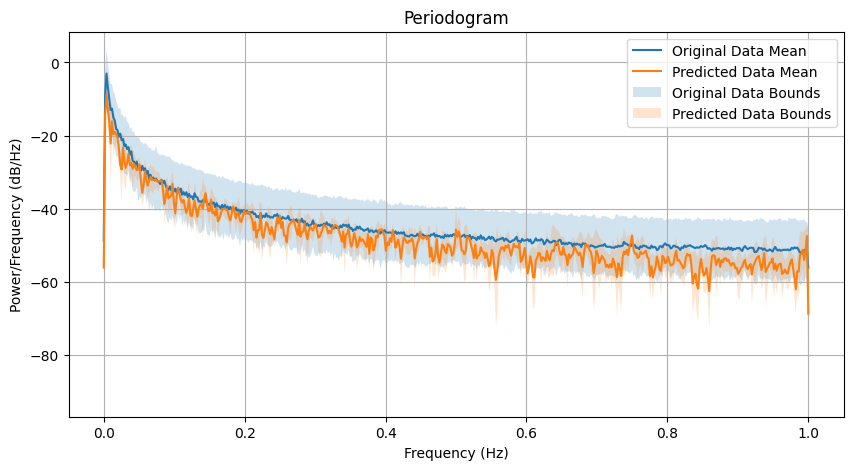

In [29]:
def generate_data(data):
    training_number = np.random.randint(0, data.shape[0] - 1)
    image_number = np.random.randint(0, new_images.shape[0] - 1)
    array1 = data[training_number].reshape(-1)
    array2 = new_images[image_number].reshape(-1)
    return array1, array2

# Number of datasets to generate
n_datasets = 100

# Lists to store periodograms for each dataset
all_periodograms_original = []
all_periodograms_predicted = []

# Generate n datasets and calculate periodograms
for _ in range(n_datasets):
    array1, array2 = generate_data(data)
    
    # Calculate periodogram using scipy.signal.periodogram
    freqs1, psd1 = periodogram(array1, fs=2, nfft=1024, window='hann')
    freqs2, psd2 = periodogram(array2, fs=2, nfft=1024, window='hann')
    
    all_periodograms_original.append(10 * np.log10(psd1))  # Convert to dB for better visualization
    all_periodograms_predicted.append(10 * np.log10(psd2))  # Convert to dB for better visualization

# Calculate mean and variance for original and predicted data
mean_original = np.mean(all_periodograms_original, axis=0)
variance_original = np.var(all_periodograms_original, axis=0)

mean_predicted = np.mean(all_periodograms_predicted, axis=0)
variance_predicted = np.var(all_periodograms_predicted, axis=0)

# Plot mean and bounds for periodogram
plt.figure(figsize=(10, 5))
plt.plot(freqs1, mean_original, label='Original Data Mean')
plt.plot(freqs2, mean_predicted, label='Predicted Data Mean')

plt.fill_between(freqs1, mean_original - np.sqrt(variance_original), mean_original + np.sqrt(variance_original), alpha=0.2, label='Original Data Bounds')
plt.fill_between(freqs2, mean_predicted - np.sqrt(variance_predicted), mean_predicted + np.sqrt(variance_predicted), alpha=0.2, label='Predicted Data Bounds')

plt.title('Periodogram')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, smoothing_factor=0.99, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        # Loss tracking metrics
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.vario_loss_tracker = tf.keras.metrics.Mean(name="vario_loss")
        self.periodogram_loss_tracker = tf.keras.metrics.Mean(name="periodogram_loss")
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

        # Loss scaling factors (dynamically adjusted)
        self.reconstruction_scale = tf.Variable(1.0, trainable=False, dtype=tf.float32)
        self.kl_scale = tf.Variable(1.0, trainable=False, dtype=tf.float32)
        self.vario_scale = tf.Variable(1.0, trainable=False, dtype=tf.float32)
        self.periodogram_scale = tf.Variable(1.0, trainable=False, dtype=tf.float32)

        # Smoothing factor for scale updates (can be adjusted dynamically)
        self.smoothing_factor = tf.Variable(smoothing_factor, trainable=False, dtype=tf.float32)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.vario_loss_tracker,
            self.periodogram_loss_tracker,
        ]

    @tf.function
    def compute_variogram_tf(self, image, mode='isotropic', angle_deg=None,
                            num_samples=100000, num_bins=30, max_dist=None, random_seed=None):
        """
        Computes an approximate empirical variogram for a single image with direction control.

        Args:
            image (tf.Tensor): A tensor of shape (height, width, channels).
            mode (str): One of 'isotropic', 'horizontal', 'vertical', or 'angle'.
            angle_deg (float): Direction angle in degrees (only used if mode == 'angle').
            num_samples (int): Number of random pixel pairs to sample.
            num_bins (int): Number of bins to group distances.
            max_dist (float): Maximum lag value to consider.
            random_seed (int): Seed for the random number generator (optional).

        Returns:
            bin_centers (tf.Tensor): Lag bin centers.
            gamma (tf.Tensor): Semi-variance values per bin.
        """
        if random_seed is not None:
            tf.random.set_seed(random_seed)

        image_shape = tf.shape(image)
        height, width = image_shape[0], image_shape[1]
        max_base = tf.minimum(height, width)

        # Helper: get random base coordinates
        y1 = tf.random.uniform((num_samples,), 0, height, dtype=tf.int32)
        x1 = tf.random.uniform((num_samples,), 0, width, dtype=tf.int32)

        # Determine displacements
        if mode == 'isotropic':
            y2 = tf.random.uniform((num_samples,), 0, height, dtype=tf.int32)
            x2 = tf.random.uniform((num_samples,), 0, width, dtype=tf.int32)

        else:
            if max_dist is None:
                max_lag = max_base // 3
            else:
                max_lag = tf.cast(max_dist, tf.int32)

            lag = tf.random.uniform((num_samples,),
                                    minval=tf.cast(1, tf.float32),
                                    maxval=tf.cast(max_lag, tf.float32),
                                    dtype=tf.float32)

            if mode == 'horizontal':
                dx = tf.cast(tf.round(lag), tf.int32)
                dy = tf.zeros_like(dx)
            elif mode == 'vertical':
                dx = tf.zeros_like(lag, dtype=tf.int32)
                dy = tf.cast(tf.round(lag), tf.int32)
            elif mode == 'angle':
                if angle_deg is None:
                    raise ValueError("If mode is 'angle', angle_deg must be specified.")
                angle_rad = angle_deg * tf.constant(np.pi / 180.0, dtype=tf.float32)
                dx = tf.cast(tf.round(lag * tf.cos(angle_rad)), tf.int32)
                dy = tf.cast(tf.round(lag * tf.sin(angle_rad)), tf.int32)
            else:
                raise ValueError("mode must be one of ['isotropic', 'horizontal', 'vertical', 'angle']")

            # Calculate second set of coords, ensure they are valid
            x2 = tf.clip_by_value(x1 + dx, 0, width - 1)
            y2 = tf.clip_by_value(y1 + dy, 0, height - 1)

        # Stack to form coordinate pairs
        indices1 = tf.stack([y1, x1], axis=1)
        indices2 = tf.stack([y2, x2], axis=1)

        # Gather pixel values
        pixel1 = tf.gather_nd(image, indices1)
        pixel2 = tf.gather_nd(image, indices2)

        # Compute squared differences (averaged over channels)
        sq_diffs = tf.reduce_mean(tf.square(tf.cast(pixel1, tf.float32) - tf.cast(pixel2, tf.float32)), axis=-1)

        # Compute distances
        distances = tf.sqrt(tf.square(tf.cast(x1, tf.float32) - tf.cast(x2, tf.float32)) +
                            tf.square(tf.cast(y1, tf.float32) - tf.cast(y2, tf.float32)))

        valid = distances > 0.0
        distances = tf.boolean_mask(distances, valid)
        sq_diffs = tf.boolean_mask(sq_diffs, valid)

        if max_dist is None:
            max_dist = tf.sqrt(tf.cast(height ** 2 + width ** 2, tf.float32)) / 3.0

        bin_edges = tf.linspace(0.0, max_dist, num_bins + 1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
        bin_inds = tf.searchsorted(bin_edges, distances, side='right') - 1

        def compute_bin(i):
            mask = tf.equal(bin_inds, i)
            sq_diffs_bin = tf.boolean_mask(sq_diffs, mask)
            count = tf.size(sq_diffs_bin)
            semi_variance = tf.cond(
                tf.greater(count, 0),
                lambda: 0.5 * tf.reduce_mean(sq_diffs_bin),
                lambda: tf.constant(0.0, dtype=tf.float32)
            )
            return semi_variance

        gamma = tf.map_fn(compute_bin, tf.range(num_bins), dtype=tf.float32)
        return bin_centers, gamma



    @tf.function
    def compute_variogram_loss(
        self,
        original,
        generated,
        num_samples=100000,
        num_bins=30,
        max_dist=None,
        random_seed=None
    ):
        """
        Computes a composite variogram-based loss (isotropic + horizontal + vertical)
        between original and generated images.

        Args:
            original, generated (tf.Tensor): Tensors of shape (batch, H, W, C)
            num_samples (int): Number of pixel pairs
            num_bins (int): Number of bins for distances
            max_dist (float): Max lag distance
            random_seed (int): Seed for reproducibility

        Returns:
            tf.Tensor: Scalar loss combining isotropic, horizontal, and vertical components.
        """

        def compute_loss_per_image(args):
            orig, gen = args
            losses = []
            for mode in ['isotropic', 'horizontal', 'vertical']:
                _, gamma_orig = self.compute_variogram_tf(
                    orig, mode=mode, num_samples=num_samples, num_bins=num_bins,
                    max_dist=max_dist, random_seed=random_seed
                )
                _, gamma_gen = self.compute_variogram_tf(
                    gen, mode=mode, num_samples=num_samples, num_bins=num_bins,
                    max_dist=max_dist, random_seed=random_seed
                )
                losses.append(tf.reduce_mean(tf.square(gamma_orig - gamma_gen)))
            return tf.reduce_mean(losses)

        losses = tf.map_fn(compute_loss_per_image, (original, generated), dtype=tf.float32)
        return tf.reduce_mean(losses)

    def compute_periodogram_loss(self, original, generated, epsilon=1e-8):
        """Computes the difference between periodograms of original and generated images."""
        original = tf.cast(original, tf.complex64)
        generated = tf.cast(generated, tf.complex64)

        fft_original = tf.signal.fft2d(original[..., 0])
        fft_generated = tf.signal.fft2d(generated[..., 0])

        fft_original = tf.signal.fftshift(fft_original, axes=[-2, -1])
        fft_generated = tf.signal.fftshift(fft_generated, axes=[-2, -1])

        power_original = tf.abs(fft_original) ** 2
        power_generated = tf.abs(fft_generated) ** 2

        power_original /= tf.reduce_max(power_original, axis=[1, 2], keepdims=True) + epsilon
        power_generated /= tf.reduce_max(power_generated, axis=[1, 2], keepdims=True) + epsilon

        periodogram_loss = tf.reduce_mean(tf.square(power_original - power_generated))
        return periodogram_loss

    def update_scales(self, reconstruction_loss, kl_loss, vario_loss, periodogram_loss):
        """Dynamically updates the loss scaling factors using exponential smoothing."""
        alpha = self.smoothing_factor  # Dynamic smoothing factor

        self.reconstruction_scale.assign(alpha * self.reconstruction_scale + (1 - alpha) * reconstruction_loss)
        self.kl_scale.assign(alpha * self.kl_scale + (1 - alpha) * kl_loss)
        self.vario_scale.assign(alpha * self.vario_scale + (1 - alpha) * vario_loss)
        self.periodogram_scale.assign(alpha * self.periodogram_scale + (1 - alpha) * periodogram_loss)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Compute raw losses
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            vario_loss = self.compute_variogram_loss(data, reconstruction)
            periodogram_loss = 0 #self.compute_periodogram_loss(data, reconstruction)

            # Update loss scales dynamically
            self.update_scales(reconstruction_loss, kl_loss, vario_loss, periodogram_loss)

            # Compute normalized losses
            normalized_reconstruction_loss = reconstruction_loss / (self.reconstruction_scale + 1e-8)
            normalized_kl_loss = kl_loss / (self.kl_scale + 1e-8)
            normalized_vario_loss = vario_loss / (self.vario_scale + 1e-8)
            normalized_periodogram_loss = periodogram_loss / (self.periodogram_scale + 1e-8)

            # Compute total loss based on normalized values
            # total_loss = (normalized_reconstruction_loss +
            #             normalized_kl_loss +
            #             0.001 * normalized_vario_loss +
            #             0.001 * normalized_periodogram_loss)
            vario_lambda = 1e+7 #1e+7 best value so far, 1e+9 no model convergence, 1e+5 too low
            kl_lambda = 10
            total_loss = (reconstruction_loss +
                        kl_lambda * kl_loss +
                        vario_lambda * vario_loss)
                        #(1e+9) * periodogram_loss)

        # Compute gradients and apply updates
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update loss trackers (store raw losses for early stopping & model checkpoints)
        self.total_loss_tracker.update_state(total_loss)  # Normalized total loss
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)  # Raw loss
        self.kl_loss_tracker.update_state(kl_loss)  # Raw loss
        self.vario_loss_tracker.update_state(vario_lambda * vario_loss)  # Raw loss
        self.periodogram_loss_tracker.update_state(periodogram_loss)  # Raw loss

        return {
            "loss": self.total_loss_tracker.result(),  # Normalized total loss
            "raw_reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "raw_kl_loss": self.kl_loss_tracker.result(),
            "raw_vario_loss": self.vario_loss_tracker.result(),
            # "raw_periodogram_loss": self.periodogram_loss_tracker.result(),
            # "normalized_reconstruction_loss": normalized_reconstruction_loss,
            # "normalized_kl_loss": normalized_kl_loss,
            # "normalized_vario_loss": normalized_vario_loss,
            # "normalized_periodogram_loss": normalized_periodogram_loss,
        }



In [13]:
vae = VAE(encoder, decoder, smoothing_factor=0.90)
vae.compile(optimizer=tf.keras.optimizers.Adam())
epochs = 400
history = vae.fit(data, epochs=epochs, batch_size=8, shuffle=True,  callbacks=[reduce_lr, early_stopping])

Epoch 1/400
Instructions for updating:
Use fn_output_signature instead
196/196 [==============================] - 267s 1s/step - loss: 14492.4070 - raw_reconstruction_loss: 14159.7380 - raw_kl_loss: 0.1362 - raw_vario_loss: 331.3069 - lr: 0.0010
Epoch 2/400
196/196 [==============================] - 242s 1s/step - loss: 2816.3724 - raw_reconstruction_loss: 2637.9299 - raw_kl_loss: 5.0248 - raw_vario_loss: 128.1938 - lr: 0.0010
Epoch 3/400
196/196 [==============================] - 248s 1s/step - loss: 1459.0855 - raw_reconstruction_loss: 1223.5642 - raw_kl_loss: 16.9368 - raw_vario_loss: 66.1534 - lr: 0.0010
Epoch 4/400
196/196 [==============================] - 267s 1s/step - loss: 1188.2870 - raw_reconstruction_loss: 959.5222 - raw_kl_loss: 18.2959 - raw_vario_loss: 45.8064 - lr: 0.0010
Epoch 5/400
196/196 [==============================] - 266s 1s/step - loss: 1082.7787 - raw_reconstruction_loss: 863.1507 - raw_kl_loss: 17.9104 - raw_vario_loss: 40.5239 - lr: 0.0010
Epoch 6/400
196/

In [17]:
total_loss = history.history['loss']
reconstruction_loss = history.history['raw_reconstruction_loss']
kl_loss = history.history["raw_kl_loss"]
vario_loss = history.history["raw_vario_loss"]
#periodogram_loss = history.history["raw_periodogram_loss"]
#total_loss = reconstruction_loss + kl_loss + vario_loss #+ periodogram_loss

Text(0, 0.5, 'loss')

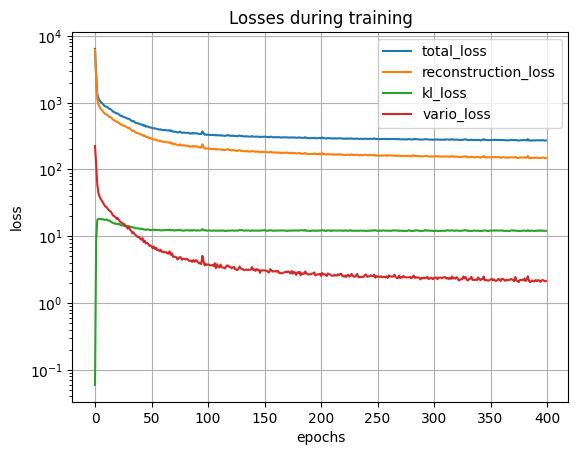

In [18]:
plt.semilogy(total_loss, label = 'total_loss')
plt.semilogy(reconstruction_loss, label = 'reconstruction_loss')
plt.semilogy(kl_loss, label = 'kl_loss')
plt.semilogy(vario_loss, label = 'vario_loss')
#plt.semilogy(periodogram_loss, label = 'periodogram_loss')
plt.title('Losses during training')
plt.grid()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

1/1 [==============================] - 1s 1s/step


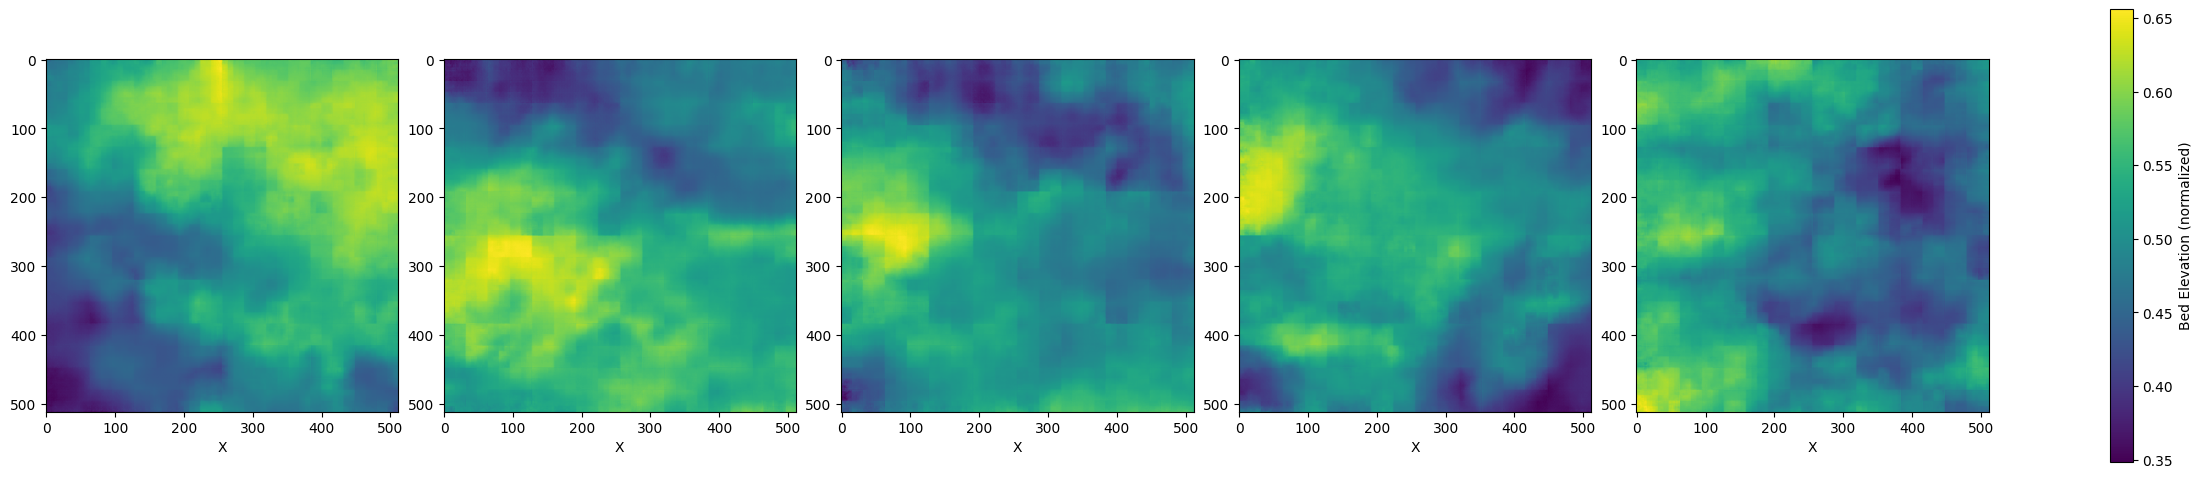

In [19]:
def generate_images(decoder, n=5):
    # Sample from the latent space
    #latent_dim = 128  # This is the latent_dim defined in the VAE model
    random_latent_vectors = np.random.normal(size=(n, latent_dim))

    # Decode to generate images
    generated_images = decoder.predict(random_latent_vectors)

    return generated_images

# Generate new images
new_images = generate_images(decoder, n=5)

# Plot the generated images
plt.figure(figsize=(25, 5))

for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    img = plt.imshow(new_images[i].reshape(512, 512))
    plt.xlabel('X')

# Add a single color bar for all subplots
plt.tight_layout()
cbar = plt.colorbar(img, ax=[ax for ax in plt.gcf().axes], label='Bed Elevation (normalized)')

plt.show()

In [20]:
def generate_data(data):
    # Replace this with your data generation logic
    #image_number = np.random.randint(0, new_images.shape[0] - 1)
    training_number = np.random.randint(0, data.shape[0] - 1)
    generated_image = generate_images(decoder, 1).reshape(512,512,1)
    training_image = data[training_number]
    return generated_image, training_image

# Number of datasets to generate
n_datasets = 50

# Lists to store variograms for each dataset
all_variograms_generated = []
all_variograms_training = []

# Generate n datasets and calculate variograms
for _ in range(n_datasets):
    generated_image, training_image = generate_data(data)
    x = range(generated_image.shape[1])
    y = range(generated_image.shape[0])

    # Assuming gs.vario_estimate returns bin_center and gamma
    bin_center_generated, gamma_generated = gs.vario_estimate((x, y), generated_image)
    bin_center_training, gamma_training = gs.vario_estimate((x, y), training_image)

    all_variograms_generated.append(gamma_generated)
    all_variograms_training.append(gamma_training)

# Calculate mean and variance for generated and training data
mean_generated = np.mean(all_variograms_generated, axis=0)
variance_generated = np.var(all_variograms_generated, axis=0)

mean_training = np.mean(all_variograms_training, axis=0)
variance_training = np.var(all_variograms_training, axis=0)

1/1 [==============================] - 0s 14ms/step


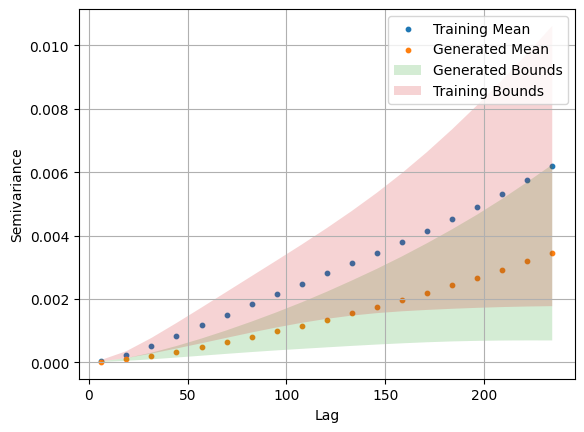

In [21]:
# Plot mean and bounds
plt.scatter(bin_center_training, mean_training, label='Training Mean', s=10)
plt.scatter(bin_center_generated, mean_generated, label='Generated Mean', s=10)

plt.fill_between(bin_center_generated, mean_generated - np.sqrt(variance_generated), mean_generated + np.sqrt(variance_generated), alpha=0.2, label='Generated Bounds')
plt.fill_between(bin_center_training, mean_training - np.sqrt(variance_training), mean_training + np.sqrt(variance_training), alpha=0.2, label='Training Bounds')

plt.xlabel('Lag')
plt.ylabel('Semivariance')
plt.legend()
plt.grid()
plt.show()

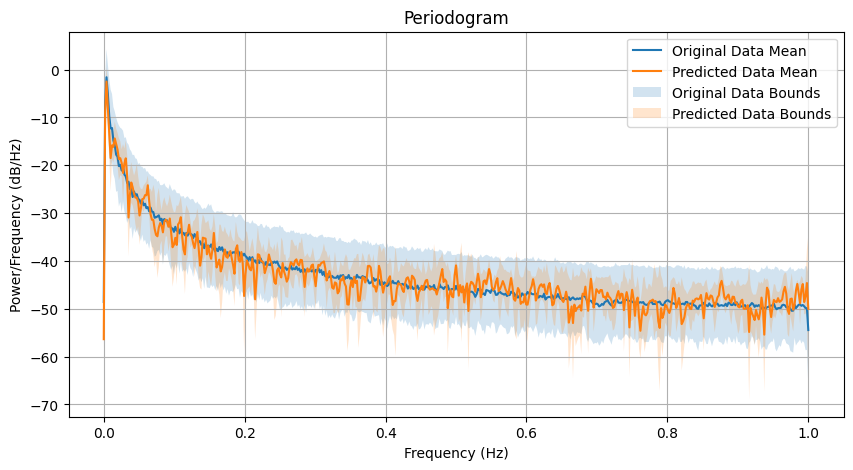

In [22]:
def generate_data(data):
    training_number = np.random.randint(0, data.shape[0] - 1)
    image_number = np.random.randint(0, new_images.shape[0] - 1)
    array1 = data[training_number].reshape(-1)
    array2 = new_images[image_number].reshape(-1)
    return array1, array2

# Number of datasets to generate
n_datasets = 100

# Lists to store periodograms for each dataset
all_periodograms_original = []
all_periodograms_predicted = []

# Generate n datasets and calculate periodograms
for _ in range(n_datasets):
    array1, array2 = generate_data(data)
    
    # Calculate periodogram using scipy.signal.periodogram
    freqs1, psd1 = periodogram(array1, fs=2, nfft=1024, window='hann')
    freqs2, psd2 = periodogram(array2, fs=2, nfft=1024, window='hann')
    
    all_periodograms_original.append(10 * np.log10(psd1))  # Convert to dB for better visualization
    all_periodograms_predicted.append(10 * np.log10(psd2))  # Convert to dB for better visualization

# Calculate mean and variance for original and predicted data
mean_original = np.mean(all_periodograms_original, axis=0)
variance_original = np.var(all_periodograms_original, axis=0)

mean_predicted = np.mean(all_periodograms_predicted, axis=0)
variance_predicted = np.var(all_periodograms_predicted, axis=0)

# Plot mean and bounds for periodogram
plt.figure(figsize=(10, 5))
plt.plot(freqs1, mean_original, label='Original Data Mean')
plt.plot(freqs2, mean_predicted, label='Predicted Data Mean')

plt.fill_between(freqs1, mean_original - np.sqrt(variance_original), mean_original + np.sqrt(variance_original), alpha=0.2, label='Original Data Bounds')
plt.fill_between(freqs2, mean_predicted - np.sqrt(variance_predicted), mean_predicted + np.sqrt(variance_predicted), alpha=0.2, label='Predicted Data Bounds')

plt.title('Periodogram')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid(True)
plt.show()